This notebook illustrates how to generate an ensemble of model predictions by arbitrarily sampling the latent space of electrophysiological features.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.input_builder import build_input, build_input_with_embeddings, extract_scaled_e_features
from utils.model_utils import load_model
from utils.latent_sampler import sampled_2d_latent_space
from utils.plotting import plot_ensemble_prediction

**Step 1: Set up parameters**

In [2]:
device      = "cpu"
amplitude   = 0.5
num_samples = 200

dt_original       = 0.02
downsample_factor = 3

features_to_embed = ["slope", "intercept"]

embedding_config = {"sine_embeddings_freq": 9,
                    "scale_sine_embeddings": "freq",
                    "amplitude_embeddings": False,
                    "hof_model_embeddings": 1,
                    "e_features_to_embed": features_to_embed}

**Step 2: Load electrophysiological features**

In [3]:
normalised_features = extract_scaled_e_features(neuron_identifier="PVALB_689331391", 
                                                path_to_features='../data/e_features/pvalb_689331391_ephys_sim_features.csv', 
                                                features_to_embed=features_to_embed)

**Step 3: Load trained $\texttt{NOBLE}$ model**

In [4]:
model_path = 'noble_models/FNO_nmodes-256_in-23_out-1_nlayers-12_projectionratio-4_hc-24_AmpEmbeddings-FreqScaledNeRF-nfreq-9_HoFEmbeddings-FreqScaledNeRF-nfreq-1_bestepoch-296.pth'
model = load_model(model_path, device)

Loading FNO model with modes=256, in_channels=23, out_channels=1, nlayers=12, projection_ratio=4,  hidden_channels=24, device=cpu.



**Step 4: Sample latent space**

In [5]:
known_hof_models     = np.arange(0, 60)
hof_test             = np.array([32, 2, 12, 40, 5, 52, 21, 29, 16, 37])
hof_train            = np.setdiff1d(known_hof_models, hof_test)
features_train       = normalised_features[normalised_features["hof_model"].isin(hof_train)]

latent_samples = sampled_2d_latent_space(normalised_features_train=features_train, 
                                         features_to_embed=features_to_embed,
                                         num_samples=num_samples)

sampled_models = {"intercept": torch.tensor(latent_samples[:, 0], dtype=torch.float32), 
                  "slope": torch.tensor(latent_samples[:, 1], dtype=torch.float32)}

**Step 5: Build input with sampled model embeddings**

In [6]:
input_batch_transformed = build_input_with_embeddings(input_batch=build_input(amplitude, num_samples, device), 
                                                      embedding_config=embedding_config, 
                                                      features_to_embed=features_to_embed, 
                                                      normalised_features=normalised_features, 
                                                      device=device,
                                                      sampled_embeddings=sampled_models)

**Step 6: Generate ensemble predictions**

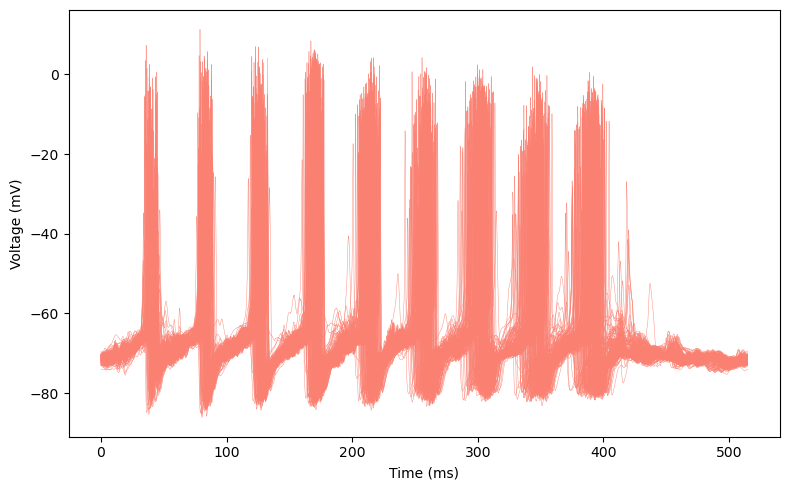

In [7]:
with torch.no_grad():
    output_batch = model(input_batch_transformed)

plot_ensemble_prediction(predicted_output = output_batch.squeeze(1).cpu().numpy(), 
                         num_samples = num_samples, 
                         dt_downsampled = dt_original * downsample_factor, 
                         save_title="arbitrary_ensemble_prediction")